In [1]:
import os

download_name = "glove.6B.100d.txt.gz"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://github.com/allenai/spv2/blob/master/model/{download_name}?raw=true")
    print(response)
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()
        
name = "glove.6B.100d.txt"
if not os.path.exists(name):
    import gzip
    with gzip.open(download_name, 'rb') as gzf, open(name, 'wb') as fp:
        fp.write(gzf.read())

download_name = "wordsim_similarity_goldstandard.txt"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/lectures/p04/{download_name}")
    print(response)
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()

In [2]:
try:
    from annoy import AnnoyIndex
except ImportError:
    !pip install annoy
    from annoy import AnnoyIndex

import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PreTrained Embeddings

In [3]:
class PreTrainedEmbeddings(object):
    def __init__(self, word_to_index, word_vectors):
        self.word_to_index = word_to_index
        self.word_vectors = word_vectors
        self.index_to_word = {v: k for k, v in self.word_to_index.items()}
        
        self.index = AnnoyIndex(len(word_vectors[0]), metric='euclidean')
        for _, i in self.word_to_index.items():
            self.index.add_item(i, self.word_vectors[i])
        self.index.build(50)
        
    @classmethod
    def from_embeddings_file(cls, embedding_file):
        word_to_index = {}
        word_vectors = []
        with open(embedding_file) as fp:
            for line in fp.readlines():
                word, *vec = line.split()
                vec = np.array([float(x) for x in vec])                
                word_to_index[word] = len(word_to_index)
                word_vectors.append(vec)

        return cls(word_to_index, word_vectors)

    def __getitem__(self, word):
        return self.word_vectors[self.word_to_index[word]]

    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.index_to_word[n_idx] for n_idx in nn_indices]

    def get_closest_to_word(self, word, n=1):
        return self.get_closest_to_vector(self[word], n)

    def get_word_similarity(self, word1, word2):
        vec1, vec2 = self[word1], self[word2]
        return np.dot(vec1, vec2) / (np.sum(vec1 ** 2) * np.sum(vec2 ** 2)) ** 0.5

    def get_word_distance(self, word1, word2):
        vec1, vec2 = self[word1], self[word2]
        return np.sum((vec1 - vec2) ** 2) ** 0.5

    def compute_and_print_analogy(self, word1, word2, word3):
        vec1 = self[word1]
        vec2 = self[word2]
        vec3 = self[word3]

        spatial_relationship = vec2 - vec1
        vec4 = vec3 + spatial_relationship

        closest_words = self.get_closest_to_vector(vec4, n=4)
        existing_words = {word1, word2, word3}
        closest_words = [word for word in closest_words 
                              if word not in existing_words] 

        if len(closest_words) == 0:
            print("Could not find nearest neighbors for the vector!")
            return [word1, word2, word3]
        
        for word4 in closest_words:
            print(f"{word1} : {word2} :: {word3} : {word4}")
            return [word1, word2, word3, word4]

    def plot_words(self, words):
        x = np.array([self[w] for w in words])

        model = PCA(n_components=2)
        reduced = model.fit(x).transform(x)

        for (x, y), w in zip(reduced, words):
            plt.scatter(x, y, label="opla", marker=".", color="blue")
            plt.text(x+.1, y+.1, w, fontsize=12)


In [4]:
embeddings = PreTrainedEmbeddings.from_embeddings_file("glove.6B.100d.txt")

# Closest words

In [5]:
embeddings.get_closest_to_word("dog", n=4)

['dog', 'cat', 'dogs', 'pet']

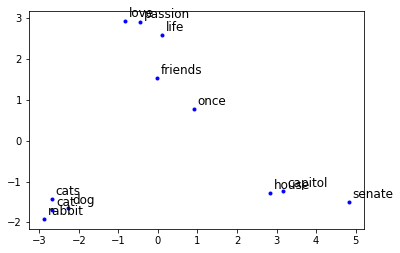

In [6]:
embeddings.plot_words(embeddings.get_closest_to_word("cat", n=4) + 
                      embeddings.get_closest_to_word("love", n=4) + 
                      embeddings.get_closest_to_word("house", n=4))

# Analogy

### The relationship between gendered nouns and pronouns

man : he :: woman : she


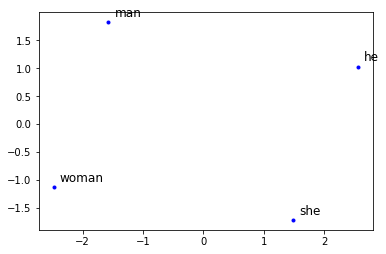

In [7]:
words = embeddings.compute_and_print_analogy("man", "he", "woman")
embeddings.plot_words(words)

### verb-noun relationships

fly : bird :: dive : shark


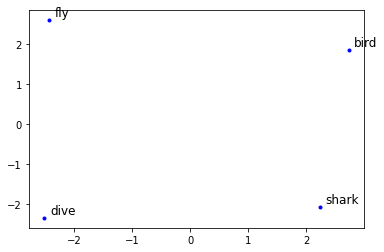

In [8]:
words = embeddings.compute_and_print_analogy("fly", "bird", "dive")
embeddings.plot_words(words)

### noun-noun relationship

cat : kitten :: dog : puppy


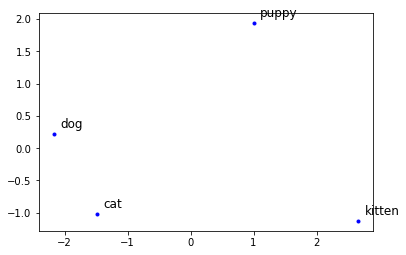

In [9]:
words = embeddings.compute_and_print_analogy("cat", "kitten", "dog")
embeddings.plot_words(words)

### hypernymy (broader category)

blue : color :: dog : animal


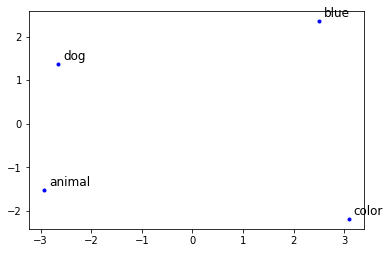

In [10]:
words = embeddings.compute_and_print_analogy("blue", "color", "dog")
embeddings.plot_words(words)

### meronymy (part-to-whole)

nose : head :: finger : hand


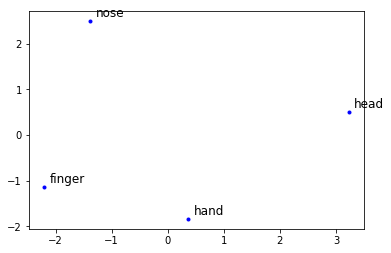

In [11]:
words = embeddings.compute_and_print_analogy("nose", "head", "finger")
embeddings.plot_words(words)

### troponymy (difference in manner)

talk : communicate :: read : interpret


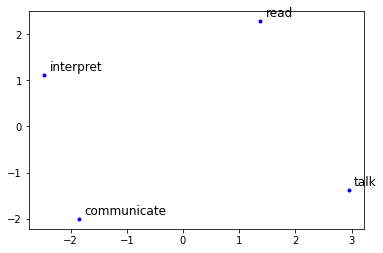

In [12]:
words = embeddings.compute_and_print_analogy("talk", "communicate", "read")
embeddings.plot_words(words)

### metonymy (convention / figure of speech)

blue : democrat :: red : republican


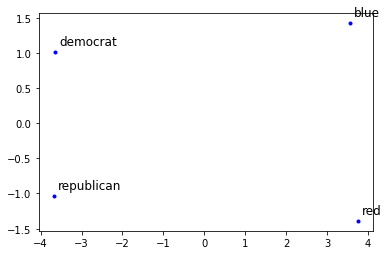

In [13]:
words = embeddings.compute_and_print_analogy("blue", "democrat", "red")
embeddings.plot_words(words)

### adjectival scales

fast : fastest :: young : youngest


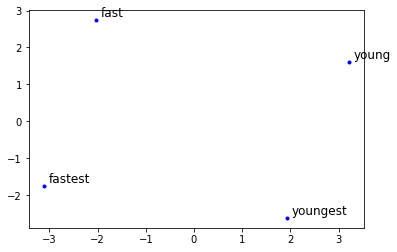

In [14]:
words = embeddings.compute_and_print_analogy("fast", "fastest", "young")
embeddings.plot_words(words)

# Coocurance in embeddings

fast : fastest :: large : smallest


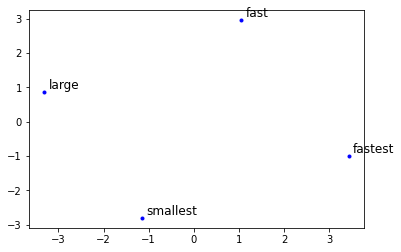

In [15]:
words = embeddings.compute_and_print_analogy("fast", "fastest", "large")
embeddings.plot_words(words)

# Similarity evaluation

wordsim353 dataset is used to determine correlation (Pearson) between human scored similarities and embedded similarities.

In [16]:
import pandas as pd

df = pd.read_csv("wordsim_similarity_goldstandard.txt", sep="\t", 
                 header=None, 
                 names=["word1", "word2", "score"]).sort_values("score", ascending=False)


def similarity(row):
    return 10*embeddings.get_word_similarity(row.word1.lower(), row.word2.lower())

df["similarity"] = df.apply(similarity, axis=1)

df

,word1,word2,score,similarity
1,tiger,tiger,10.00,10.000000
17,fuck,sex,9.44,1.435206
28,journey,voyage,9.29,7.682994
33,midday,noon,9.29,7.853312
81,dollar,buck,9.22,2.056370
...,...,...,...,...
198,rooster,voyage,0.62,0.604874
199,noon,string,0.54,0.375757
200,chord,smile,0.54,2.038110
201,professor,cucumber,0.31,-0.065899


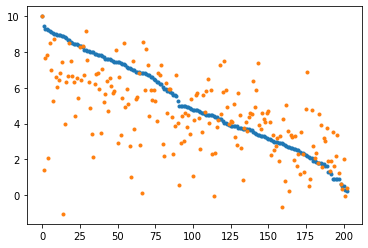

In [17]:

plt.scatter(range(len(df)), df.score.to_numpy(), marker=".")
plt.scatter(range(len(df)), df.similarity.to_numpy(), marker=".")


### Correlation 

In [18]:
df.score.corr(df.similarity, method="pearson")

0.594181312264783